# Adaptive PDE discretizations on cartesian grids
## Volume : Algorithmic tools
## Part : Domain representation
## Chapter : Finite differences, interpolation

This notebook presents the basic types of finite differences and interpolation methods that can be considered on a cartesian grid. The tools are presented in two dimensions, but apply in arbitrary dimension. They also apply in the context of:
* non-square domains, [example](SubsetRd.ipynb)
* point dependent offsets, [example](../Notebooks_NonDiv/LinearMonotoneSchemes2D.ipynb)
* vector valued functions.

[**Summary**](Summary.ipynb) of volume Algorithmic tools, this series of notebooks.

[**Main summary**](../Summary.ipynb) of the Adaptive Grid Discretizations 
	book of notebooks, including the other volumes.

# Table of contents
  * [1. Degenerate elliptic finite differences](#1.-Degenerate-elliptic-finite-differences)
    * [1.1 Testing data](#1.1-Testing-data)
    * [1.2 Upwind finite difference](#1.2-Upwind-finite-difference)
    * [1.3 Second order finite difference](#1.3-Second-order-finite-difference)
  * [2. Non degenerate elliptic finite differences](#2.-Non-degenerate-elliptic-finite-differences)
    * [2.1 Centered finite difference](#2.1-Centered-finite-difference)
    * [2.2 High order upwind finite differences](#2.2-High-order-upwind-finite-differences)
  * [3. Composite finite differences](#3.-Composite-finite-differences)
    * [3.1 Gradient](#3.1-Gradient)
    * [3.2 Hessian](#3.2-Hessian)
  * [4. Interpolation](#4.-Interpolation)
    * [4.1 Linear splines](#4.1-Linear-splines)
    * [4.2 Quadratic splines](#4.2-Quadratic-splines)
    * [4.3 Cubic splines](#4.3-Cubic-splines)
    * [4.4 Vector data](#4.4-Vector-data)
  * [5. Functions associated with an AD variable](#5.-Functions-associated-with-an-AD-variable)
    * [5.1 Taylor expansions](#5.1-Taylor-expansions)
    * [5.2 Sparse differentiation](#5.2-Sparse-differentiation)



**Acknowledgement.** The experiments presented in these notebooks are part of ongoing research, 
some of it with PhD student Guillaume Bonnet, in co-direction with Frederic Bonnans.

Copyright Jean-Marie Mirebeau, University Paris-Sud, CNRS, University Paris-Saclay

## 0. Import the required libraries

In [1]:
import sys; sys.path.insert(0,"..") # Allow imports from parent directory
#from Miscellaneous import TocTools; print(TocTools.displayTOC('FiniteDifferences','Algo'))

In [2]:
from agd import FiniteDifferences as fd
from agd import AutomaticDifferentiation as ad
from agd import Interpolation
from agd import LinearParallel as lp

In [3]:
import numpy as np
from matplotlib import pyplot as plt

In [4]:
def reload_packages():
    from Miscellaneous.rreload import rreload
    global ad,fd,Interpolation,lp
    ad,fd,Interpolation,lp = rreload([ad,fd,Interpolation,lp],rootdir="../..")

## 1. Degenerate elliptic finite differences

The finite difference presented in this section are a typical ingredient of monotone numerical schemes, see the corresponding [volume](../../Notebooks_NonDiv/Summary.ipynb). 

### 1.1 Testing data

In order to test the finite difference and interpolation methods, we need some polynomial functions.

In [5]:
def u1(X): return X[0]+2*X[1]
def u2(X): return X[0]**2+2*(2*X[0]*X[1])+3*X[1]**2
def u3(X): return X[0]**3+X[0]*X[1]**2

def u123(X): return ad.array( (u1(X),u2(X),u3(X)) )

We also need to choose a direction, with *integer coordinates*, for the finite differences.

In [6]:
e = (1,2)

Let us also define a domain, here a square.

In [7]:
aX,h = np.linspace(-1,1,retstep=True)
X=np.array(np.meshgrid(aX,aX,indexing='ij'))
shape = X.shape[1:]

def close(u,v,k):
    """Wether u and v are close in the domain minus k boundary layers."""
    interior = np.full(shape,False)
    interior[k:-k,k:-k]=True
    return np.allclose(u[...,interior],v[...,interior])

The following variables are used for validation, by comparison with automatic differentiation.

In [8]:
X_ad = ad.Dense.identity(constant=X,shape_free=(2,))
X_ad2 = ad.Dense2.identity(constant=X,shape_free=(2,))

du1  = u1(X_ad).gradient()
du2  = u2(X_ad).gradient()
ddu2 = u2(X_ad2).hessian()
du3  = u3(X_ad).gradient()
ddu3 = u3(X_ad2).hessian()

_e = fd.as_field(e,shape)
du1_e  = lp.dot_VV(du1,_e)
du2_e  = lp.dot_VV(du2,_e)
ddu2_e = lp.dot_VAV(_e,ddu2,_e)
du3_e  = lp.dot_VV(du3,_e)

### 1.2 Upwind finite difference
$$
    \frac{u(x+he)-u(x)} h = <\nabla u(x),e> + O(h).
$$

In [9]:
Du1_e = fd.DiffUpwind(u1(X),e,h)
assert close(Du1_e,du1_e,2)

### 1.3 Second order finite difference
$$
    \frac{u(x+he)-2u(x)+u(x-he)}{h^2} = <e,\nabla^2 u(x),e> + O(h^2).
$$

In [10]:
DDu2_e = fd.Diff2(u2(X),e,h)
assert close(DDu2_e,ddu2_e,2)

## 2. Non degenerate elliptic finite differences

The following finite differences are not degenerate elliptic. They may nevertheless be encountered in degenerate elliptic schemes, if their lack of ellipticity is suitably compensated, of within a filtered scheme.

### 2.1 Centered finite difference
$$
    \frac{u(x+h e)-u(x-h e)} {2 h} = <\nabla u(x),e> + O(h^2). 
$$

In [11]:
Du2_e = fd.DiffCentered(u2(X),e,h)
assert close(Du2_e,du2_e,2)

### 2.2 High order upwind finite differences
$$
    \frac{-u(x+2he)+4u(x+he)-3u(x)}{2h} = <\nabla u(x),e> + O(h^2)
$$

In [12]:
Du2_e = fd.DiffUpwind(u2(X),e,h,order=2)
assert close(Du2_e,du2_e,4)

$$
    \frac{2 u(x+3he)-9 u(x+2he)+18 u(x+he)-11 u(x)}{6h} = <\nabla u(x),e> + O(h^3)
$$

In [13]:
Du3_e = fd.DiffUpwind(u3(X),e,h,order=3)
assert close(Du3_e,du3_e,6)

## 3. Composite finite differences
The following finite differences can be used to estimate numerically the derivatives of a function, but they are rarely adequate for building numerical schemes. We denote by $e_i$ the $i$-th element of the canonical basis.

### 3.1 Gradient
$$
    \frac{u(x+h e_i)-u(x-he_i)}{2h} = \frac {\partial u} {\partial x_i} + O(h^2), \qquad 0 \leq i < d.
$$

In [14]:
Du2 = fd.DiffGradient(u2(X),gridScale=h)
assert close(Du2,du2,2)

In [15]:
Du2.shape

(2, 50, 50)

### 3.2 Hessian
$$
    \frac{u(x+h e_i)-2u(x)+u(x-he_i)}{h^2} = \frac {\partial^2 u} {\partial^2 x_i} + O(h^2),
$$
for all $0\leq i < d$, and 
$$
    \frac{u(x+h e_i+h e_j)+u(x-he_i-h e_j)-u(x+h e_i -h e_j) - u(x-h e_i+he_j)}{4h^2} = \frac {\partial^2 u} {\partial x_i \partial x_j} + O(h^2), 
$$
for all distinct $i,j$.

In [16]:
DDu2 = fd.DiffHessian(u2(X),gridScale=h)
assert close(DDu2,ddu2,2)

In [17]:
DDu2.shape

(2, 2, 50, 50)

## 4. Interpolation

Let us define a finer grid.

In [18]:
aX_ = np.linspace(-1,1,80)
X_=np.array(np.meshgrid(aX_,aX_,indexing='ij'))

In [19]:
Interp = Interpolation.UniformGridInterpolation

### 4.1 Linear splines

(Piecewise) Linear splines are continuous, and reproduce linear functions.
They are second order consistent
$$
    U_1^h(x) = u(x)+O(h^2).
$$

In [20]:
U1 = Interp(X,u1(X),order=1)
assert np.allclose(U1(X_),u1(X_))

The spline can be differentiated, and yields the a first order consistent estimation of the gradient, *except possibly at boundary points*.
$$
    \nabla U_1^h(x) = \nabla u(x) + O(h)
$$

In [21]:
dU1 = U1(X_ad).gradient()
assert close(dU1,du1,1)

### 4.2 Quadratic splines

Quadratic splines are continuously differentiable, and reproduce quadratic functions.
We use a not-a-knot boundary condition : in one dimension, the second derivative is continuous accross the second node from the left.
$$
    U_2^h(x) = u(x)+O(h^3).
$$

In [22]:
U2 = Interp(X,u2(X),order=2)
assert np.allclose(U2(X_),u2(X_))

The spline can be differentiated, one time or two times, and yields a second order consistent estimate of the gradient, and a first order consistent estimate of the hessian, *except possibly at boundary points*.
$$
    \nabla U_2^h(x) = \nabla u(x) + O(h^2),
$$
$$
    \nabla^2 U_2^h(x) = \nabla^2 u(x) + O(h).
$$

In [23]:
dU2 = U2(X_ad).gradient()
assert close(dU2,du2,1)

In [24]:
ddU2 = U2(X_ad2).hessian()
assert close(ddU2,ddu2,1)

### 4.3 Cubic splines

Cubic splines are twice continuously differentiable, and reproduce cubic functions.
We use a not-a-knot boundary condition : in one dimension, the third derivative is continuous accross the second node from the left, and likewise from the right.
$$
    U_3^h(x) = u(x)+O(h^4).
$$

In [25]:
U3 = Interp(X,u3(X),order=3)
assert np.allclose(U3(X_),u3(X_))

The spline can be differentiated two times, and yields consistent estimates of the gradient and hessian, *except possibly at boundary points*.
$$
    \nabla U_3^h(x) = \nabla u(x) + O(h^3),
$$
$$
    \nabla^2 U_3^h(x) = \nabla^2 u(x) + O(h^2).
$$

In [26]:
dU3 = U3(X_ad).gradient()
assert close(dU3,du3,1)

In [27]:
ddU3 = U3(X_ad2).hessian()
assert close(ddU3,ddu3,1)

### 4.4 Vector data

In [28]:
U123 = Interp(X,u123(X),order=3)
assert np.allclose(U123(X_),u123(X_))

## 5. Functions associated with an AD variable



### 5.1 Taylor expansions

The automatic differentiation classes store a Taylor expansion of the approximated function, which can be evaluated directly. The tangent, adjoint, and hessian operators may also be extracted.

In [29]:
x = np.array([0.2,0.5])
H = X-fd.as_field(x,shape)
x_ad  = ad.Dense.identity(constant=x)
x_ad2 = ad.Dense2.identity(constant=x)

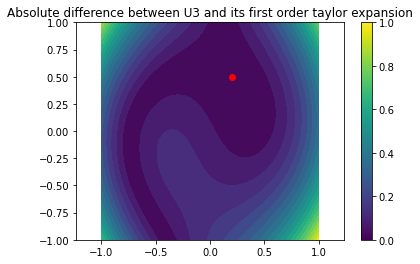

In [30]:
plt.title("Absolute difference between U3 and its first order taylor expansion")
plt.contourf(*X, np.abs(U3(x_ad).as_func(H) - U3(X)), levels=20);
plt.axis('equal'); plt.scatter(*x,color='red'); plt.colorbar();

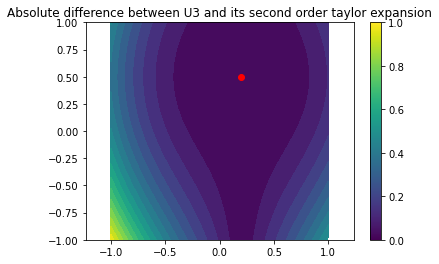

In [31]:
plt.title("Absolute difference between U3 and its second order taylor expansion")
plt.contourf(*X, np.abs(U3(x_ad2).as_func(H) - U3(X)), levels=20);
plt.axis('equal'); plt.scatter(*x,color='red'); plt.colorbar();

### 5.2 Sparse differentiation

When differentiating a high dimensional function, for instance in the context of a PDE discretization scheme, sparse automatic differentiation becomes for reasons of memory and computation cost. We check here the consistency of the related Taylor expansions. 

In [32]:
x_sp  = ad.Sparse.identity(constant=x)
x_sp2 = ad.Sparse2.identity(constant=x)

In [33]:
assert np.allclose(U3(x_sp ).as_func(H), U3(x_ad ).as_func(H))
assert np.allclose(U3(x_sp2).as_func(H), U3(x_ad2).as_func(H))

The sparse classes also provide tangent, adjoint, and hessian linear operators, stored as opaque sparse matrices.

In [34]:
tangent_op = U3(x_sp ).tangent_operator()
hessian_op = U3(x_sp2).hessian_operator()
H_ = H.reshape(2,-1) # Depth must be at most two

In [35]:
assert np.allclose(U3(x_sp ).as_func(H_), U3(x) + tangent_op*H_)
assert np.allclose(U3(x_sp2).as_func(H_), U3(x) + tangent_op*H_ + 0.5*lp.dot_VV(H_,hessian_op*H_))

Finally, we check the adjoint operator.

In [36]:
adjoint_op = U3(x_sp).adjoint_operator()

np.random.seed(42)
R_ = np.random.rand(1,H_.shape[1])

In [37]:
assert np.allclose(lp.dot_VV(R_,tangent_op*H_), lp.dot_VV(H_,adjoint_op*R_))